In [1]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import os
import collections

import matplotlib.animation as animation
import itertools
from itertools import combinations 


import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 

from sklearn import metrics
 

from torch_geometric.data import Data
from torch_geometric.data import DataLoader as DataLoaderGraph
from torch_geometric.data import Dataset as DatasetGraph
from torch_geometric.data import Batch as BatchGraph
from torch_geometric.transforms import RandomNodeSplit as masking

from torch_geometric.nn import GCNConv, BatchNorm, SAGEConv, SGConv, ChebConv
from torch_geometric.utils.convert import to_networkx

import networkx as nx

In [2]:
class MeanAggregator(nn.Module):
    def __init__(self):
        super(MeanAggregator, self).__init__()

    def forward(self, features, A):
        x = torch.bmm(A, features)
        return x


In [3]:
class GraphConv(nn.Module):
    def __init__(self, in_dim, out_dim, agg):
        super(GraphConv, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = nn.Parameter(torch.FloatTensor(in_dim * 2, out_dim))
        self.bias = nn.Parameter(torch.FloatTensor(out_dim))
        init.xavier_uniform_(self.weight)
        init.constant_(self.bias, 0)
        self.agg = agg()
        
    def forward(self, features, adj_matrix):
        batch_size, num_nodes, node_dim = features.shape
        assert node_dim == self.in_dim
        agg_feats = self.agg(features, adj_matrix)
        cat_feats = torch.cat([features, agg_features], dim=2)
        out = torch.einsum('bnd,df->bnf', (cat_feats, self.weight))
        out = F.relu(out + self.bias)
        return out

In [4]:
with open("git_web_ml/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)

edges=pd.read_csv("git_web_ml/musae_git_edges.csv")
target_df=pd.read_csv("git_web_ml/musae_git_target.csv")

In [5]:
print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [13]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]


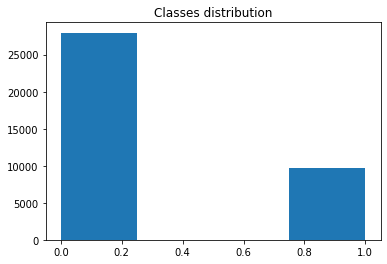

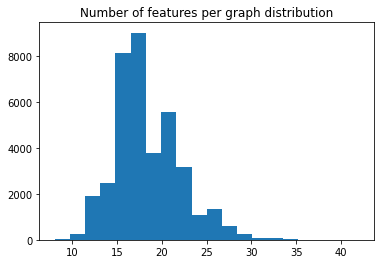

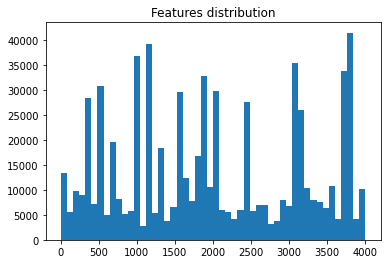

In [14]:
plt.hist(target_df.ml_target,bins=4);
plt.title("Classes distribution")
plt.show()

plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()

plt.hist(feats,bins=50)
plt.title("Features distribution")
plt.show()

In [15]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)

    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)

    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

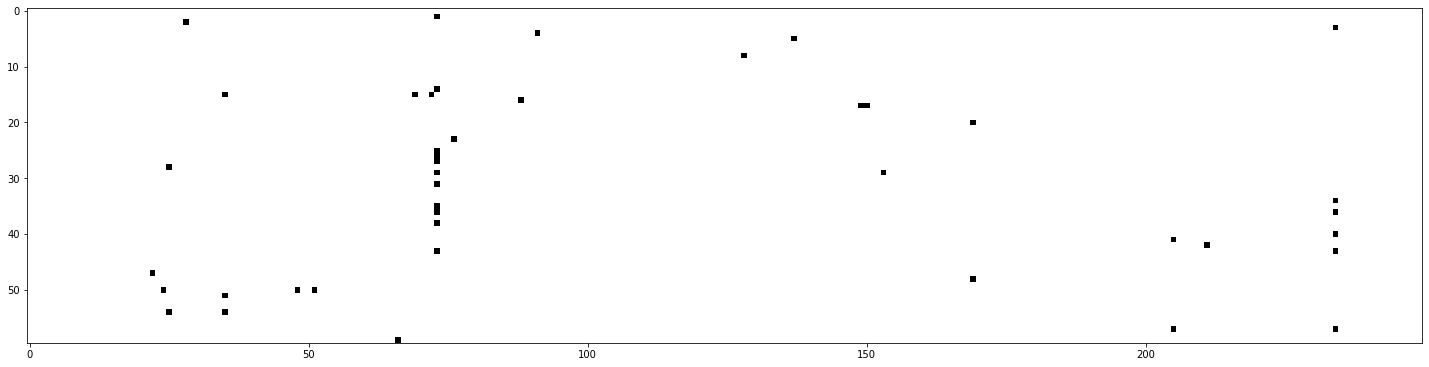

In [16]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');

In [17]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [18]:
def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
        
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

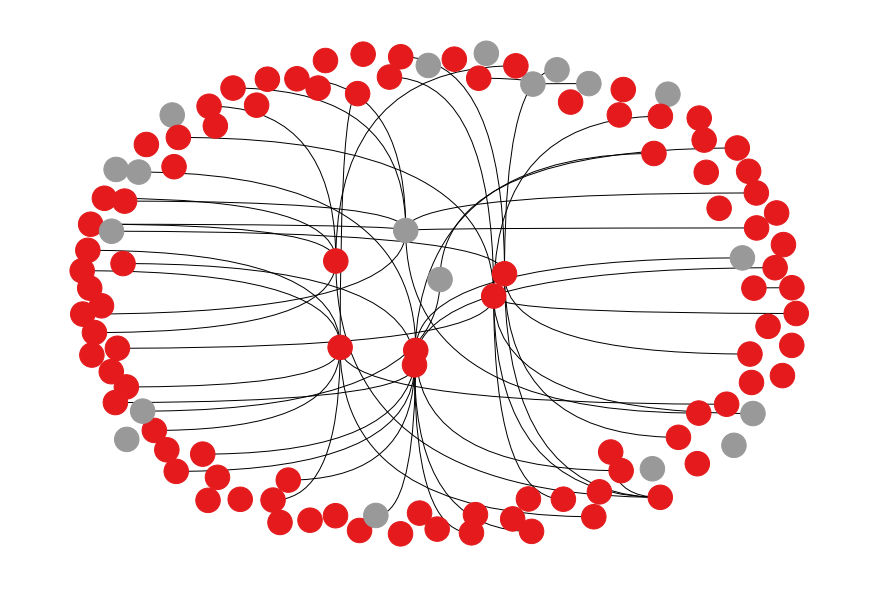

In [19]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)

In [ ]:
data_encoded,_=encode_data(light=False)

In [ ]:
g=construct_graph(data_encoded=data_encoded,light=False)

In [ ]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

In [ ]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()


        self.conv1 = GCNConv(num_of_feat, f)

        self.conv2 = GCNConv(f, 2)


    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
          
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        return x

In [ ]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    

In [ ]:
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)    

In [ ]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    
    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]
    
    for ep in range(epochs+1):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss]
        
        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]

        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy

    plt.plot(train_losses)  
    plt.plot(val_losses)
    plt.plot(test_losses)  

    plt.show()
    
    plt.plot(train_accuracies) 
    plt.plot(val_accuracies)
    plt.plot(test_accuracies) 
    plt.show()


In [ ]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_social(net,g,epochs=50,lr=0.1)